---
# 7. An End-to-End Classification Test
As the last step, you are given a dataset called `data/ccdefault.csv`. The dataset represents default of credit card clients. It has 30,000 cases and 24 different attributes. More details about the dataset is available at `data/ccdefault.txt`. In this task you should make three models, compare their results and conclude the ideal solution. Here are the suggested steps:
1. Load the data.
2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed).
3. Train a model to predict the target variable (risk of `default`).
  - Employ three different models (logistic regression, decision tree, and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).
4. What more would you do with this data? Anything to help you devise a better solution?

## We'll do the first necessaty imports

In [1]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession

spark=SparkSession.builder.master("local").appName("monday_exam").getOrCreate()

## We'll get the data

In [2]:
ccdefault = spark.read.format('csv').options(header=True, inferSchema=True).load("data/ccdefault.csv")

## Some basic operations to understand the data

In [3]:
# See the schema of the data
ccdefault.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- DEFAULT: integer (nullable = tru

In [4]:
ccdefault.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|      1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|       0|    1000|    1000|    1000|       0|    2000|    

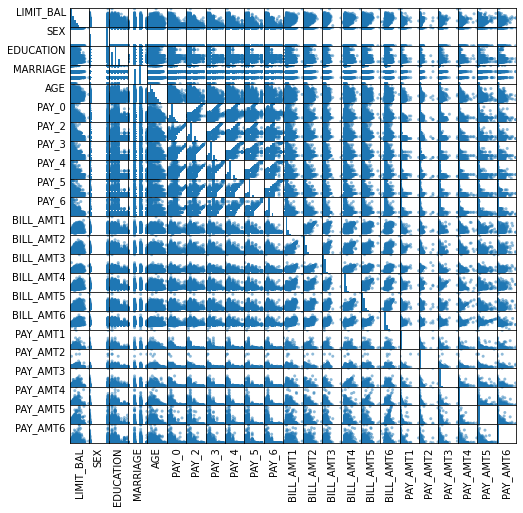

In [5]:
from pyspark.sql.functions import expr
from pandas.plotting import scatter_matrix

# ccdefault_cleaned = ccdefault.withColumn("PAY_AVG", expr('(PAY_0 + PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6)/6'))
# ccdefault_cleaned1 = ccdefault_cleaned.withColumn("PAY_AMT_AVG", expr('(PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6'))
# ccdefault_cleaned2 = ccdefault_cleaned1.withColumn("BILL_AVG", expr('(BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6'))

# ccdefault_cleaned_final = ccdefault_cleaned2.drop('PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
#                                                   'PAY_AMT1',' PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6')

# ccdefault_cleaned_final.show(5)
# ccdefault_cleaned_final.write.csv('ccdefault_cleaned_final.csv', header=True)
# numeric_data = ccdefault_cleaned_final.select([ x for x in ccdefault_cleaned_final.columns if x != 'DEFAULT' and x != 'ID']).toPandas()
numeric_data = ccdefault.select([ x for x in ccdefault.columns if x != 'DEFAULT' and x != 'ID']).toPandas()
axs = scatter_matrix(numeric_data, figsize=(8, 8))

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())


## Let's prepare the data for the machine learning algorithm

In [6]:
# Renamed the DEFAULT column to label
# ccdefaultRenamed = ccdefault_cleaned_final.withColumnRenamed('DEFAULT', 'label')
ccdefaultRenamed = ccdefault.withColumnRenamed('DEFAULT', 'label')
# Select the columns without the label column
colAttr = [col for col in ccdefaultRenamed.columns if col != 'ID' and col != 'label']

## We can verify that the columns dont have missing values

In [7]:
for c in colAttr:
    count = ccdefaultRenamed.filter(
        c+" is   NULL" or c+"is ''" or c+"is  NaN" or c+"is  null").count()
    print(c+" column has " + str(count) + " missing values\n")


LIMIT_BAL column has 0 missing values

SEX column has 0 missing values

EDUCATION column has 0 missing values

MARRIAGE column has 0 missing values

AGE column has 0 missing values

PAY_0 column has 0 missing values

PAY_2 column has 0 missing values

PAY_3 column has 0 missing values

PAY_4 column has 0 missing values

PAY_5 column has 0 missing values

PAY_6 column has 0 missing values

BILL_AMT1 column has 0 missing values

BILL_AMT2 column has 0 missing values

BILL_AMT3 column has 0 missing values

BILL_AMT4 column has 0 missing values

BILL_AMT5 column has 0 missing values

BILL_AMT6 column has 0 missing values

PAY_AMT1 column has 0 missing values

PAY_AMT2 column has 0 missing values

PAY_AMT3 column has 0 missing values

PAY_AMT4 column has 0 missing values

PAY_AMT5 column has 0 missing values

PAY_AMT6 column has 0 missing values



## Now let's create our features vector

In [8]:
# First let's transform our attributes into a big vector
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=colAttr, outputCol='features')  # to_be_scaled
ccdefaultFeatured = vectorAssembler.transform(ccdefaultRenamed)

ccdefaultFeatured.show(5)


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|            features|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+--------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|    1|[20000.0,2.0,2.0,...|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Now let's create our model

In [9]:
# First we select the columns we need
dataset = ccdefaultFeatured.withColumn(
    colName="features", col=ccdefaultFeatured["features"])
dataset = ccdefaultFeatured.withColumn(
    colName="label", col=ccdefaultFeatured["label"])
# Then we create our train and test split
trainSet, testSet = dataset.randomSplit([0.7, 0.3])

trainSet.select("features").show(20, False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|[20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0]                                         |
|[120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0]                       |
|[90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0]             |
|[50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233

## 1- Logistic Regression

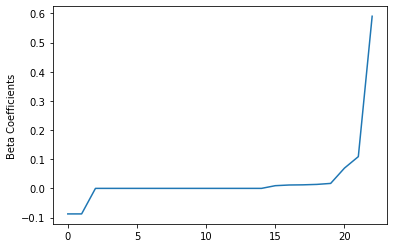

Intercept: -1.2137812795731373

Feature: 0, Score: -0.00000
Feature: 1, Score: 0.01215
Feature: 2, Score: -0.08754
Feature: 3, Score: -0.08758
Feature: 4, Score: 0.01158
Feature: 5, Score: 0.59033
Feature: 6, Score: 0.10888
Feature: 7, Score: 0.06960
Feature: 8, Score: 0.00924
Feature: 9, Score: 0.01364
Feature: 10, Score: 0.01702
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: -0.00001
Feature: 18, Score: -0.00001
Feature: 19, Score: -0.00000
Feature: 20, Score: -0.00000
Feature: 21, Score: -0.00000
Feature: 22, Score: -0.00000
0.8106826051895072


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression
# We train the model
logisticRegression = LogisticRegression(maxIter = 10, regParam = 0)
model = logisticRegression.fit(trainSet)


beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


# The summary of the learning process
trainingSummary = model.summary

print("Intercept: " + str(model.intercept)+"\n")

for i, v in enumerate(model.coefficients):
    print('Feature: %0d, Score: %.5f' % (i, v))

print(trainingSummary.accuracy)


Root Mean Squared Error (RMSE) on test data = 0.4347811462558946


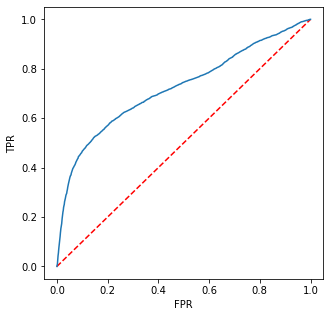

In [11]:
# Now we evaluate the model
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

# Make the predictions on the test data
predictions = model.transform(testSet)

# select (prediction, true label) and compute test error.
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = " + str(rmse))


plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


Precision and recall

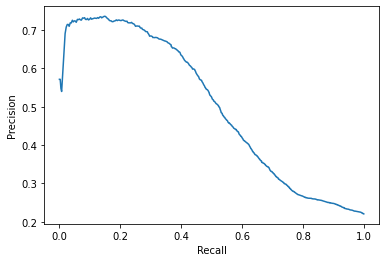

In [12]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Evaluation of the Logistic Regression

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7174350100006975


## 2- Decision Tree

In [14]:
from pyspark.ml.classification import DecisionTreeClassifier

decisionTreeClassifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# train the model
model = decisionTreeClassifier.fit(trainSet)
# make predictions on the test data
predictions = model.transform(testSet)
predictions.select('label', 'rawPrediction',
                   'prediction', 'probability').show(10)


+-----+----------------+----------+--------------------+
|label|   rawPrediction|prediction|         probability|
+-----+----------------+----------+--------------------+
|    0|[14838.0,2481.0]|       0.0|[0.85674692534210...|
|    0|[14838.0,2481.0]|       0.0|[0.85674692534210...|
|    1|   [715.0,399.0]|       0.0|[0.64183123877917...|
|    0|[14838.0,2481.0]|       0.0|[0.85674692534210...|
|    0|   [715.0,399.0]|       0.0|[0.64183123877917...|
|    0|[14838.0,2481.0]|       0.0|[0.85674692534210...|
|    0|[14838.0,2481.0]|       0.0|[0.85674692534210...|
|    1|   [188.0,642.0]|       1.0|[0.22650602409638...|
|    0|[14838.0,2481.0]|       0.0|[0.85674692534210...|
|    0|[14838.0,2481.0]|       0.0|[0.85674692534210...|
+-----+----------------+----------+--------------------+
only showing top 10 rows



## Evaluation of the Decision Tree

In [15]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions,
      {evaluator.metricName: "areaUnderROC"})))
# select(prediction, true label) and compute test error
rmse = evaluator.evaluate(predictions)
print("Mean Squared Error (RMSE) on test data = " + str(rmse))


Test Area Under ROC: 0.3157013134637301
Mean Squared Error (RMSE) on test data = 0.3157013134637301


## 3- Random Forest

In [16]:
from pyspark.ml.classification import RandomForestClassifier

randomForestClassifier = RandomForestClassifier(labelCol="label", featuresCol="features")

# train the model
model = randomForestClassifier.fit(trainSet)

# make predictions on the test data
predictions = model.transform(testSet)
predictions.select("prediction", "label", "features").show(5)

# select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = " + str(rmse))


+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|    0|[50000.0,1.0,2.0,...|
|       0.0|    0|[140000.0,2.0,3.0...|
|       0.0|    1|[70000.0,1.0,2.0,...|
|       0.0|    0|[250000.0,1.0,1.0...|
|       0.0|    0|[50000.0,2.0,3.0,...|
+----------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.4253962755533068


## Evaluation of the Random Forest

Test Area Under ROC: 0.7689428186850247


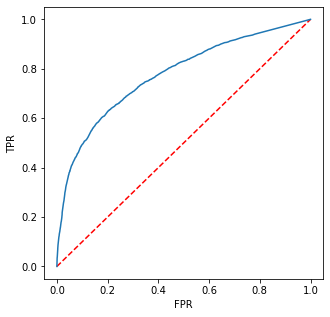

In [17]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions,
      {evaluator.metricName: "areaUnderROC"})))

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# The random forest model seems to have the best result among de three tested here, maybe that would be the method that we would recommand 